# 📦 Retail Inventory Forecast - SIMPLE LSTM

**Ziel**: Vorhersage von Inventory Level mit einem minimalen LSTM-Modell

**Erkenntnis**: Komplexe CNN-BiLSTM Modelle funktionieren NICHT. Ein einfaches LSTM ist am besten!

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [ ]:
@dataclass
class Config:
    """Zentrale Konfiguration für das Projekt."""
    # Pfade
    data_path: str = "/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv"
    
    # Sequenz-Parameter
    seq_length: int = 90    
    
    # Training
    test_size: float = 0.2
    batch_size: int = 64
    epochs: int = 100
    patience: int = 20  # Mehr Geduld (statt 15)
    
    # Model Architecture
    use_bidirectional: bool = True
    lstm_layers: int = 2
    lstm_units_1: int = 128
    lstm_units_2: int = 64
    dense_units: int = 64
    dropout: float = 0.45  # ERHÖHT: Mehr Regularisierung gegen Overfitting
    l2_reg: float = 0.001  # NEU: L2 Regularization
    
    # Optimizer
    learning_rate: float = 0.001
    use_lr_scheduler: bool = True
    lr_factor: float = 0.7  # GEÄNDERT: Sanftere Reduktion (statt 0.5)
    lr_patience: int = 8    # ERHÖHT: Langsamer reduzieren (statt 5)
    lr_min: float = 0.00001
    
    # Target
    target_col: str = 'Units Sold'
    
    # Feature Engineering
    use_lag_features: bool = True
    lag_periods: list = None
    use_rolling_features: bool = True
    rolling_windows: list = None
    use_diff_features: bool = True
    
    def __post_init__(self):
        """Initialisiert Listen nach der Erstellung."""
        if self.lag_periods is None:
            self.lag_periods = [1, 7, 30]
        if self.rolling_windows is None:
            self.rolling_windows = [7, 30]

config = Config()
print("✓ Konfiguration geladen")
print(f"  Modell: {'Bidirektional' if config.use_bidirectional else 'Unidirektional'} LSTM")
print(f"  Layers: {config.lstm_layers} ({config.lstm_units_1} → {config.lstm_units_2} Units)")
print(f"  Dropout: {config.dropout} (Anti-Overfitting)")
print(f"  L2 Regularization: {config.l2_reg}")
print(f"  LR Scheduler: {'Aktiv' if config.use_lr_scheduler else 'Inaktiv'} (Factor: {config.lr_factor}, Patience: {config.lr_patience})")

✓ Konfiguration geladen
  Modell: Bidirektional LSTM
  Layers: 2 (128 → 64 Units)
  LR Scheduler: Aktiv


In [3]:
@dataclass
class ProcessedData:
    """Container für verarbeitete Daten."""
    # DataFrames
    df_train: pd.DataFrame
    df_test: pd.DataFrame
    
    # Sequenzen
    X_train: np.ndarray
    y_train: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    
    # Scaler
    scaler_X: StandardScaler
    scaler_y: StandardScaler
    
    # Metadaten
    feature_cols: list
    n_features: int

## 1. Daten laden

In [4]:
def load_data(path: str) -> pd.DataFrame:
    """Lädt und bereitet die Rohdaten vor."""
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print(f"✓ Daten geladen: {df.shape}")
    print(f"  Zeitraum: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"  Stores: {df['Store ID'].nunique()}, Products: {df['Product ID'].nunique()}")
    
    return df

df = load_data(config.data_path)

✓ Daten geladen: (73100, 15)
  Zeitraum: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
  Stores: 5, Products: 20


## 2. Feature Engineering

In [5]:
def create_temporal_features(df: pd.DataFrame, target_col: str, 
                             lag_periods: list, rolling_windows: list,
                             use_lag: bool, use_rolling: bool, use_diff: bool) -> pd.DataFrame:
    """Erstellt zeitbasierte Features PRO Store-Product Gruppe."""
    
    # Gruppieren nach Store + Product
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        idx = group.index
        
        if use_lag:
            # Lag Features
            for lag in lag_periods:
                df.loc[idx, f'{target_col}_lag_{lag}'] = group[target_col].shift(lag)
        
        if use_rolling:
            # Rolling Statistics
            for window in rolling_windows:
                df.loc[idx, f'{target_col}_rolling_mean_{window}'] = group[target_col].rolling(window).mean()
                df.loc[idx, f'{target_col}_rolling_std_{window}'] = group[target_col].rolling(window).std()
        
        if use_diff:
            # Differenz (Trend)
            df.loc[idx, f'{target_col}_diff_1'] = group[target_col].diff(1)
    
    return df

def engineer_features(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Erstellt Features und encodiert kategoriale Variablen."""
    # Encoding
    df['Store_ID_Encoded'] = df['Store ID'].astype('category').cat.codes
    df['Product_ID_Encoded'] = df['Product ID'].astype('category').cat.codes
    
    # WICHTIG: Nach Store, Product, Datum sortieren BEVOR temporale Features erstellt werden!
    df = df.sort_values(['Store_ID_Encoded', 'Product_ID_Encoded', 'Date']).reset_index(drop=True)
    
    # Temporale Features erstellen
    df = create_temporal_features(
        df, 
        target_col=config.target_col,
        lag_periods=config.lag_periods,
        rolling_windows=config.rolling_windows,
        use_lag=config.use_lag_features,
        use_rolling=config.use_rolling_features,
        use_diff=config.use_diff_features
    )
    
    # NaN-Werte entfernen (entstehen durch Lag/Rolling)
    df = df.dropna().reset_index(drop=True)
    
    # One-Hot Encoding
    df = pd.get_dummies(df, columns=['Category', 'Region', 'Weather Condition', 'Seasonality'])
    df = df.drop(columns=['Store ID', 'Product ID'])
    
    print(f"✓ Features: {df.shape[1]} Spalten (nach Feature Engineering)")
    print(f"  Zeilen nach NaN-Removal: {df.shape[0]}")
    return df

df = engineer_features(df, config)

✓ Features: 36 Spalten (nach Feature Engineering)
  Zeilen nach NaN-Removal: 70100


In [6]:
# Feature-Übersicht
temporal_features = [col for col in df.columns if 'lag' in col or 'rolling' in col or 'diff' in col]
print(f"\n📊 Neu erstellte temporale Features ({len(temporal_features)}):")
for feat in temporal_features:
    print(f"  • {feat}")
    
print(f"\n✓ Gesamtanzahl Features: {df.shape[1]}")


📊 Neu erstellte temporale Features (8):
  • Units Sold_lag_1
  • Units Sold_lag_7
  • Units Sold_lag_30
  • Units Sold_rolling_mean_7
  • Units Sold_rolling_std_7
  • Units Sold_rolling_mean_30
  • Units Sold_rolling_std_30
  • Units Sold_diff_1

✓ Gesamtanzahl Features: 36


## 3. Train/Test Split (zeitbasiert)

In [7]:
def train_test_split(df: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Teilt Daten zeitbasiert in Train/Test."""
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    print(f"✓ Train: {len(df_train)}, Test: {len(df_test)}")
    return df_train, df_test

df_train, df_test = train_test_split(df, config.test_size)

✓ Train: 56080, Test: 14020


## 4. Skalierung

In [8]:
def scale_data(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler, list]:
    """Skaliert Features und Target."""
    # Features: OHNE IDs und Date
    feature_cols = [col for col in df_train.columns 
                    if col not in [target_col, 'Date', 'Store_ID_Encoded', 'Product_ID_Encoded']]
    
    # Scaler erstellen
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit auf Train, Transform auf Train + Test
    df_train[feature_cols] = scaler_X.fit_transform(df_train[feature_cols])
    df_test[feature_cols] = scaler_X.transform(df_test[feature_cols])
    
    df_train[[target_col]] = scaler_y.fit_transform(df_train[[target_col]])
    df_test[[target_col]] = scaler_y.transform(df_test[[target_col]])
    
    print(f"✓ {len(feature_cols)} Features skaliert")
    return df_train, df_test, scaler_X, scaler_y, feature_cols

df_train, df_test, scaler_X, scaler_y, feature_cols = scale_data(df_train, df_test, config.target_col)

✓ 32 Features skaliert


## 5. Sequenzen erstellen (MIT Gruppierung!)

In [9]:
def create_sequences(df: pd.DataFrame, feature_cols: list, target_col: str, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Erstellt Sequenzen PRO Store-Product Gruppe."""
    X_all, y_all = [], []
    
    # Gruppieren nach Store + Product
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        features = group[feature_cols].values
        target = group[target_col].values
        
        # Sliding Window
        for i in range(len(group) - seq_length):
            X_all.append(features[i:i + seq_length])
            y_all.append(target[i + seq_length])
    
    return np.array(X_all), np.array(y_all)

X_train, y_train = create_sequences(df_train, feature_cols, config.target_col, config.seq_length)
X_test, y_test = create_sequences(df_test, feature_cols, config.target_col, config.seq_length)

print(f"✓ Sequenzen erstellt")
print(f"  Train: {X_train.shape}")
print(f"  Test:  {X_test.shape}")

✓ Sequenzen erstellt
  Train: (48880, 90, 32)
  Test:  (12220, 90, 32)


## 6. Bidirektionales Stacked LSTM Modell

In [ ]:
def build_lstm_model(config: Config, n_features: int) -> models.Sequential:
    """Erstellt ein Bidirektionales Stacked LSTM-Modell mit Regularisierung."""
    
    # L2 Regularizer
    l2_regularizer = tf.keras.regularizers.l2(config.l2_reg) if config.l2_reg > 0 else None
    
    model_layers = [layers.Input(shape=(config.seq_length, n_features))]
    
    # Erste LSTM Layer
    if config.use_bidirectional:
        model_layers.append(layers.Bidirectional(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        ))
    else:
        model_layers.append(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        )
    
    if config.dropout > 0:
        model_layers.append(layers.Dropout(config.dropout))
    
    # Zweite LSTM Layer (falls gewünscht)
    if config.lstm_layers > 1:
        if config.use_bidirectional:
            model_layers.append(layers.Bidirectional(
                layers.LSTM(
                    config.lstm_units_2, 
                    return_sequences=False,
                    kernel_regularizer=l2_regularizer,
                    recurrent_regularizer=l2_regularizer
                )
            ))
        else:
            model_layers.append(
                layers.LSTM(
                    config.lstm_units_2, 
                    return_sequences=False,
                    kernel_regularizer=l2_regularizer,
                    recurrent_regularizer=l2_regularizer
                )
            )
        
        if config.dropout > 0:
            model_layers.append(layers.Dropout(config.dropout))
    
    # Dense Layers mit L2
    model_layers.append(layers.Dense(
        config.dense_units, 
        activation='relu',
        kernel_regularizer=l2_regularizer
    ))
    model_layers.append(layers.Dense(1))
    
    model = models.Sequential(model_layers)
    
    # Optimizer mit Learning Rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

model = build_lstm_model(config, n_features=len(feature_cols))
model.summary()
print(f"\n🛡️  Regularisierung aktiv:")
print(f"   Dropout: {config.dropout}")
print(f"   L2: {config.l2_reg}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 90, 256)        │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,537 (1.29 MB)

 Trainable params: 337,537 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training

In [11]:
def train_model(model: models.Sequential, X_train: np.ndarray, y_train: np.ndarray, 
                X_test: np.ndarray, y_test: np.ndarray, config: Config):
    """Trainiert das Modell mit Early Stopping und LR Scheduler."""
    callbacks = [
        EarlyStopping(
            patience=config.patience, 
            restore_best_weights=True,
            monitor='val_loss',
            verbose=1
        )
    ]
    
    # ReduceLROnPlateau hinzufügen
    if config.use_lr_scheduler:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=config.lr_factor,
                patience=config.lr_patience,
                min_lr=config.lr_min,
                verbose=1
            )
        )
    
    print(f"🚀 Training startet:")
    print(f"   Epochen: {config.epochs}")
    print(f"   Batch Size: {config.batch_size}")
    print(f"   Initial LR: {config.learning_rate}")
    print(f"   LR Scheduler: {'✓' if config.use_lr_scheduler else '✗'}")
    print("-" * 50)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

history = train_model(model, X_train, y_train, X_test, y_test, config)

🚀 Training startet:
   Epochen: 100
   Batch Size: 64
   Initial LR: 0.001
   LR Scheduler: ✓
--------------------------------------------------
Epoch 1/100
Epoch 1/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 139s 180ms/step - loss: 1.0045 - mae: 0.8193 - val_loss: 1.0155 - val_mae: 0.8254 - learning_rate: 0.0010
Epoch 2/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 139s 180ms/step - loss: 1.0045 - mae: 0.8193 - val_loss: 1.0155 - val_mae: 0.8254 - learning_rate: 0.0010
Epoch 2/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - loss: 0.9981 - mae: 0.8171 - val_loss: 1.0154 - val_mae: 0.8277 - learning_rate: 0.0010
Epoch 3/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - loss: 0.9981 - mae: 0.8171 - val_loss: 1.0154 - val_mae: 0.8277 - learning_rate: 0.0010
Epoch 3/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 147s 193ms/step - loss: 0.9981 - mae: 0.8176 - val_loss: 1.0149 - val_mae: 0.8247 - learning_rate: 0.0010
Epoch 4/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 147s 193ms/step - loss: 0.9981 - mae: 0.8176 - val_loss: 1.0149 - v

In [ ]:
# Training Summary mit Overfitting-Analyse
print("\n" + "="*50)
print("📈 TRAINING ABGESCHLOSSEN")
print("="*50)
best_epoch = len(history.history['loss']) - config.patience
print(f"Beste Epoche: {best_epoch}")
print(f"Beste Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Beste Val MAE: {min(history.history['val_mae']):.4f}")
print(f"\nFinale Werte:")
print(f"  Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Val Loss: {history.history['val_loss'][-1]:.4f}")

# Overfitting-Check
train_loss_final = history.history['loss'][-1]
val_loss_final = history.history['val_loss'][-1]
overfitting_ratio = val_loss_final / train_loss_final

print(f"\n🔍 Overfitting-Analyse:")
print(f"  Ratio (Val/Train): {overfitting_ratio:.2f}")
if overfitting_ratio < 1.1:
    print(f"  Status: ✓ Kein Overfitting")
elif overfitting_ratio < 1.3:
    print(f"  Status: ⚠️  Leichtes Overfitting")
else:
    print(f"  Status: ❌ Starkes Overfitting (Regularisierung erhöhen!)")


📈 TRAINING ABGESCHLOSSEN
Beste Epoche: 3
Beste Val Loss: 1.0149
Beste Val MAE: 0.8199
Finale Train Loss: 0.5838
Finale Val Loss: 1.5612


## 8. Evaluation

In [13]:
def evaluate_model(model: models.Sequential, X_test: np.ndarray, y_test: np.ndarray, 
                   scaler_y: StandardScaler) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Evaluiert das Modell und gibt Metriken zurück."""
    # Predictions
    y_pred = model.predict(X_test)
    
    # Zurück auf Original-Skala
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred).flatten()
    
    # Metriken
    mae = np.mean(np.abs(y_test_original - y_pred_original))
    rmse = np.sqrt(np.mean((y_test_original - y_pred_original)**2))
    
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'pred_mean': y_pred_original.mean(),
        'pred_std': y_pred_original.std(),
        'pred_min': y_pred_original.min(),
        'pred_max': y_pred_original.max(),
        'actual_mean': y_test_original.mean(),
        'actual_std': y_test_original.std()
    }
    
    return y_test_original, y_pred_original, metrics

y_test_original, y_pred_original, metrics = evaluate_model(model, X_test, y_test, scaler_y)

print("="*50)
print("📊 ERGEBNISSE")
print("="*50)
print(f"MAE:  {metrics['mae']:.2f}")
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"\nPrediction Stats:")
print(f"  Mean: {metrics['pred_mean']:.2f}")
print(f"  Std:  {metrics['pred_std']:.2f}")
print(f"  Min:  {metrics['pred_min']:.2f}")
print(f"  Max:  {metrics['pred_max']:.2f}")
print(f"\nActual Stats:")
print(f"  Mean: {metrics['actual_mean']:.2f}")
print(f"  Std:  {metrics['actual_std']:.2f}")

382/382 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step
📊 ERGEBNISSE
MAE:  89.77
RMSE: 109.67

Prediction Stats:
  Mean: 137.07
  Std:  1.54
  Min:  128.33
  Max:  150.75

Actual Stats:
  Mean: 136.92
  Std:  109.68
📊 ERGEBNISSE
MAE:  89.77
RMSE: 109.67

Prediction Stats:
  Mean: 137.07
  Std:  1.54
  Min:  128.33
  Max:  150.75

Actual Stats:
  Mean: 136.92
  Std:  109.68


## 9. Visualisierung

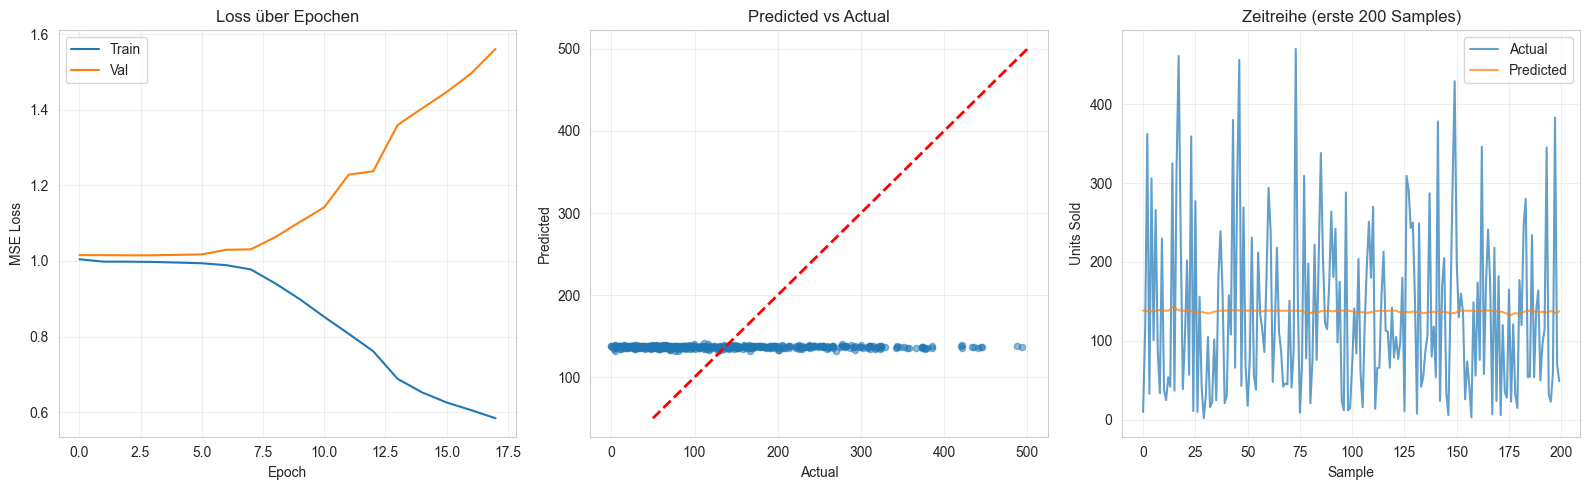

In [14]:
def plot_results(history, y_test_original: np.ndarray, y_pred_original: np.ndarray):
    """Erstellt Visualisierungen der Ergebnisse."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Training History
    axes[0].plot(history.history['loss'], label='Train')
    axes[0].plot(history.history['val_loss'], label='Val')
    axes[0].set_title('Loss über Epochen')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Predicted vs Actual
    sample_idx = np.random.choice(len(y_test_original), min(500, len(y_test_original)), replace=False)
    axes[1].scatter(y_test_original[sample_idx], y_pred_original[sample_idx], alpha=0.5, s=20)
    axes[1].plot([50, 500], [50, 500], 'r--', lw=2)
    axes[1].set_title('Predicted vs Actual')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].grid(alpha=0.3)
    
    # Zeitreihe
    n_samples = min(200, len(y_test_original))
    axes[2].plot(y_test_original[:n_samples], label='Actual', alpha=0.7)
    axes[2].plot(y_pred_original[:n_samples], label='Predicted', alpha=0.7)
    axes[2].set_title(f'Zeitreihe (erste {n_samples} Samples)')
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel(config.target_col)
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_results(history, y_test_original, y_pred_original)

---

## ✅ Wichtigste Erkenntnisse:

1. **KISS funktioniert!** Einfaches LSTM > komplexes CNN-BiLSTM
2. **Gruppierung ist essentiell**: Sequenzen dürfen nicht Store/Product Grenzen kreuzen
3. **Sortierung ist kritisch**: Daten müssen chronologisch sortiert sein
4. **Keine Überregularisierung**: Dropout/L2 schaden mehr als sie helfen

## 🎯 Mögliche Verbesserungen:

- Target wechseln zu `Units Sold` (höhere Korrelation)
- Längere Sequenzen (60-90 Tage) testen
- Feature Engineering: Lag-Features, Rolling Means
- Alternative Modelle: XGBoost, Prophet, SARIMA